사용할 분류 : Okt

사용할 모델 : LSTM(비교용) ,양방향 LSTM (Bi-LSTM)

도입해보고 그 결과 수치가 어느정도 차이 나는지 정도로 작성하기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1) 데이터 로드하기

In [3]:
train_data = pd.read_table('./dataset/ratings_train.txt')
test_data = pd.read_table('./dataset/ratings_test.txt')

train_data에 존재하는 영화 리뷰의 개수 확인

In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [5]:
train_data.head()# 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


해당 데이터는 id, document, label 총 3개의 열로 구성

결국 이 모델은 리뷰 내용을 담고있는 document와 

해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 

두 개의 열을 학습하는 모델 생성

인덱스 2번 샘플은 띄어쓰기를 하지 않아도 글을 쉽게 이해할 수 있는 

한국어의 특성으로 인해 띄어쓰기가 되어있지 않습니다. 

test_data의 리뷰 개수와 상위 5개의 샘플을 확인해봅시다.

In [6]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


test_data는 총 50,000개의 영화 리뷰가 존재합니다. 상위 5개의 샘플을 출력해봅시다.

In [7]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2) 데이터 정제하기
train_data의 데이터 중복 유무를 확인합니다.

In [8]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

총 150,000개의 샘플이 존재하는데 

document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 

약 4,000개의 중복 샘플이 존재한다는 의미입니다. 

label 열은 0 또는 1의 두 가지 값만을 가지므로 2가 출력됩니다. 

중복 샘플을 제거합니다.

In [9]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

중복 샘플을 제거하였습니다. 

중복이 제거되었는지 전체 샘플 수를 확인합니다.

In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


중복 샘플이 제거되었습니다. 

train_data에서 해당 리뷰의 긍정, 부정 유무가 기재되어있는 레이블(label) 값의 분포를 보겠습니다.

<AxesSubplot:>

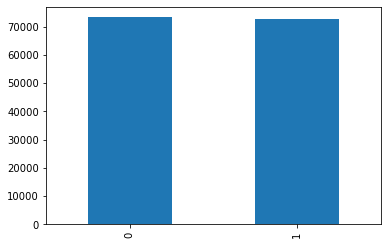

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

앞서 확인하였듯이 약 146,000개의 영화 리뷰 샘플이 존재하는데 

그래프 상으로 긍정과 부정 둘 다 약 72,000개의 샘플이 존재하여 레이블의 분포가 균일한 것처럼 보입니다. 

정확하게 몇 개인지 확인해봅시다.

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


레이블이 0인 리뷰가 근소하게 많습니다. 

리뷰 중에 Null 값을 가진 샘플이 있는지 확인합니다.

In [13]:
print(train_data.isnull().values.any())

True


True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미입니다. 

어떤 열에 존재하는지 확인해봅시다.

In [14]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 1개가 존재한다고 합니다. 

그렇다면 document 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 한 번 출력해봅시다.

In [15]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


출력 결과는 위와 같습니다. 

Null 값을 가진 샘플을 제거하겠습니다.

In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


Null 값을 가진 샘플이 제거되었습니다. 

다시 샘플의 개수를 출력하여 1개의 샘플이 제거되었는지 확인해봅시다.

In [17]:
print(len(train_data))

146182


데이터의 전처리를 수행해보겠습니다. 

위의 train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인했습니다. 

train_data로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용해보겠습니다.

우선 영어를 예시로 정규 표현식을 설명해보겠습니다. 

영어의 알파벳들을 나타내는 정규 표현식은 [a-zA-Z]입니다. 

이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식으로 

이를 응용하면 영어에 속하지 않는 구두점이나 특수문자를 제거할 수 있습니다. 

예를 들어 알파벳과 공백을 제외하고 모두 제거하는 전처리를 수행하는 예제는 다음과 같습니다.

In [18]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 되겠습니다. 

우선 자음과 모음에 대한 범위를 지정해보겠습니다. 

일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다. 

해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 아래의 링크를 참고하시기 바랍니다.

링크 : https://www.unicode.org/charts/PDF/U3130.pdf

ㄱ ~ ㅎ: 3131 ~ 314E

ㅏ ~ ㅣ: 314F ~ 3163

완성형 한글의 범위는 가 ~ 힣과 같이 사용합니다. 

해당 범위 내에 포함된 음절들은 아래의 링크에서 확인할 수 있습니다.

링크 : https://www.unicode.org/charts/PDF/UAC00.pdf

위 범위 지정을 모두 반영하여 train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해봅시다.

In [19]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

C:\Temp/ipykernel_12928/2035694706.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


상위 5개의 샘플을 다시 출력해보았는데, 정규 표현식을 수행하자 기존의 공백. 

즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었습니다. 

사실 네이버 영화 리뷰는 한글이 아니더라도 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있습니다. 

다시 말해 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것입니다. 

train_data에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인해보겠습니다.

In [20]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


C:\Temp/ipykernel_12928/1225369754.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


Null 값이 789개나 새로 생겼습니다. 

Null 값이 있는 행을 5개만 출력해볼까요?

In [21]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있습니다. 

아무런 의미도 없는 데이터므로 제거해줍니다.

In [22]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


샘플 개수가 또 다시 줄어서 145,393개가 남았습니다. 

테스트 데이터에 앞서 진행한 전처리 과정을 동일하게 진행합니다.

In [23]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


C:\Temp/ipykernel_12928/2045415552.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Temp/ipykernel_12928/2045415552.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


## 3) 토큰화

토큰화를 진행해봅시다. 

토큰화 과정에서 불용어를 제거하겠습니다. 

불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 

결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다. 

실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용할 수 있습니다.

In [24]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

여기서는 위 정도로만 불용어를 정의하고, 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt를 사용합니다. 

Okt를 복습해봅시다.

In [25]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

Okt는 위와 같이 KoNLPy에서 제공하는 형태소 분석기입니다. 

한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 

주로 형태소 분석기를 사용한다고 언급한 바 있습니다. 

stem = True를 사용하면 일정 수준의 정규화를 수행해주는데, 

예를 들어 위의 예제의 결과를 보면 '이런'이 '이렇다'로 변환되었고 

'만드는'이 '만들다'로 변환된 것을 알 수 있습니다. 

train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장합니다.

In [26]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [12:40<00:00, 191.31it/s]


상위 3개의 샘플만 출력하여 결과를 확인해봅시다.

In [27]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


형태소 토큰화가 진행된 것을 볼 수 있습니다. 

테스트 데이터에 대해서도 동일하게 토큰화를 해줍니다.

In [28]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [05:13<00:00, 155.89it/s]


지금까지 훈련 데이터와 테스트 데이터에 대해서 텍스트 전처리를 진행해보았습니다.

In [29]:
pd.Series(X_train).to_csv('./dataset/okt_x_train.csv',index=False)
pd.Series(X_test).to_csv('./dataset/okt_x_test.csv',index=False)

## 4) 정수 인코딩

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 

우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 

이는 tokenizer.word_index를 출력하여 확인 가능합니다.

In [31]:
# print(tokenizer.word_index)
# 너무 많아서 생략

단어가 43,000개가 넘게 존재합니다. 

각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 

높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미합니다. 

여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 

등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [32]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


등장 빈도가 threshold 값인 3회 미만. 

즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 

하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.87%밖에 되지 않습니다. 

아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 

그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [33]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


단어 집합의 크기는 19,416개입니다.

이를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.

In [34]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

정수 인코딩이 진행되었는지 확인하고자 X_train에 대해서 상위 3개의 샘플만 출력합니다.

In [35]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다. 

단어의 개수는 19,416개로 제한되었으므로 0번 단어 ~ 19,415번 단어까지만 사용 중입니다. 

0번 단어는 패딩을 위한 토큰임을 상기합시다. 

train_data에서 y_train과 y_test를 별도로 저장해줍니다.

In [36]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 5) 빈 샘플(empty samples) 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 

빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미합니다. 

빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업을 하겠습니다. 

각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오겠습니다.

In [37]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

drop_train에는 X_train으로부터 얻은 빈 샘플들의 인덱스가 저장됩니다. 

앞서 훈련 데이터(X_train, y_train)의 샘플 개수는 145,791개임을 확인했었습니다. 

그렇다면 빈 샘플들을 제거한 후의 샘플 개수는 몇 개일까요?

In [38]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


C:\Users\JW\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


145,162개로 샘플의 수가 줄어든 것을 확인할 수 있습니다.

## 6) 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 

전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


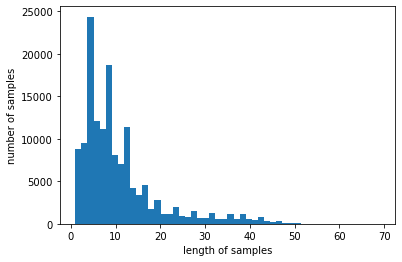

In [39]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 69이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이를 가지는 것을 볼 수 있습니다. 

모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 

특정 길이 변수를 max_len으로 정합니다. 

대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 

전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [40]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

위의 분포 그래프를 봤을 때, max_len = 30이 적당할 것 같습니다. 

이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인해봅시다.

In [41]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


전체 훈련 데이터 중 약 94%의 리뷰가 30이하의 길이를 가지는 것을 확인했습니다. 

모든 샘플의 길이를 30으로 맞추겠습니다.

In [42]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128입니다.

 모델은 다 대 일 구조의 LSTM을 사용합니다. 
 
 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다. 
 
 이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, 
 
 손실 함수로 크로스 엔트로피 함수를 사용합니다. 
 
 하이퍼파라미터인 배치 크기는 64이며, 15 에포크를 수행합니다.

EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 

검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 

정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미입니다. 

ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다. 

validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 

검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [43]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model_result/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1815/1815 [==============================] - 79s 43ms/step - loss: 0.3897 - acc: 0.8222 - val_loss: 0.3578 - val_acc: 0.8443

Epoch 00001: val_acc improved from -inf to 0.84435, saving model to ./model_result\best_model.h5
Epoch 2/15
1815/1815 [==============================] - 77s 42ms/step - loss: 0.3267 - acc: 0.8576 - val_loss: 0.3371 - val_acc: 0.8540

Epoch 00002: val_acc improved from 0.84435 to 0.85396, saving model to ./model_result\best_model.h5
Epoch 3/15
1815/1815 [==============================] - 74s 41ms/step - loss: 0.3007 - acc: 0.8721 - val_loss: 0.3265 - val_acc: 0.8595

Epoch 00003: val_acc improved from 0.85396 to 0.85947, saving model to ./model_result\best_model.h5
Epoch 4/15
1815/1815 [==============================] - 76s 42ms/step - loss: 0.2826 - acc: 0.8822 - val_loss: 0.3283 - val_acc: 0.8604

Epoch 00004: val_acc improved from 0.85947 to 0.86043, saving model to ./model_result\best_model.h5
Epoch 5/15
1815/1815 [==============================] -

## 정확도 측정
 
 훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5'를 로드

In [45]:
loaded_model = load_model('./model_result/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 14s 9ms/step - loss: 0.3354 - acc: 0.8569

 테스트 정확도: 0.8569


# 3. 리뷰 예측해보기

임의의 리뷰에 대해서 예측하는 함수를 만들어보겠습니다. 

기본적으로 현재 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용합니다. 

그리고 model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 합니다.

In [46]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [47]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

90.34% 확률로 긍정 리뷰입니다.



In [48]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

99.06% 확률로 부정 리뷰입니다.



In [49]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

99.83% 확률로 부정 리뷰입니다.



In [50]:
sentiment_predict('감독 뭐하는 놈이냐?')

99.21% 확률로 부정 리뷰입니다.



In [51]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

79.12% 확률로 긍정 리뷰입니다.



# BiLSTM으로 분류하기

In [52]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model_result/BiLSTM_Best_Model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
454/454 [==============================] - 70s 148ms/step - loss: 0.4032 - acc: 0.8158 - val_loss: 0.3649 - val_acc: 0.8398

Epoch 00001: val_acc improved from -inf to 0.83977, saving model to ./model_result\BiLSTM_Best_Model.h5
Epoch 2/15
454/454 [==============================] - 64s 140ms/step - loss: 0.3336 - acc: 0.8551 - val_loss: 0.3537 - val_acc: 0.8483

Epoch 00002: val_acc improved from 0.83977 to 0.84834, saving model to ./model_result\BiLSTM_Best_Model.h5
Epoch 3/15
454/454 [==============================] - 63s 138ms/step - loss: 0.3080 - acc: 0.8677 - val_loss: 0.3382 - val_acc: 0.8540

Epoch 00003: val_acc improved from 0.84834 to 0.85396, saving model to ./model_result\BiLSTM_Best_Model.h5
Epoch 4/15
454/454 [==============================] - 64s 141ms/step - loss: 0.2870 - acc: 0.8784 - val_loss: 0.3502 - val_acc: 0.8550

Epoch 00004: val_acc improved from 0.85396 to 0.85499, saving model to ./model_result\BiLSTM_Best_Model.h5
Epoch 5/15
454/454 [===========

In [53]:
loaded_model = load_model('./model_result/BiLSTM_Best_Model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 17s 11ms/step - loss: 0.3393 - acc: 0.8523
테스트 정확도: 0.8523


In [54]:
sentiment_predict('이걸 보고 암세포가 암에 걸려 죽어버렸습니다')

98.02% 확률로 부정 리뷰입니다.



In [55]:
sentiment_predict('아 집에 가고 싶다')

55.34% 확률로 부정 리뷰입니다.



In [56]:
sentiment_predict('내가 단편 영화 만들어도 이것보단 잘 나오겠다')

93.71% 확률로 부정 리뷰입니다.

